In [1]:
from pathlib import Path
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

%load_ext autoreload
%autoreload 2

import math

In [2]:
from utils.encoding import compute_directional_threat, Ship, Asteroid, map_threat_to_stim_freqs
from utils.visualize import visualize_game, plot_directional_stim
from utils.stimulation import StimConfig, generate_directional_trains
from utils.game_physics import GameState



## 1. Compute directional threat

Threats: Threat(left=0.49, center=0.0, right=0.37)


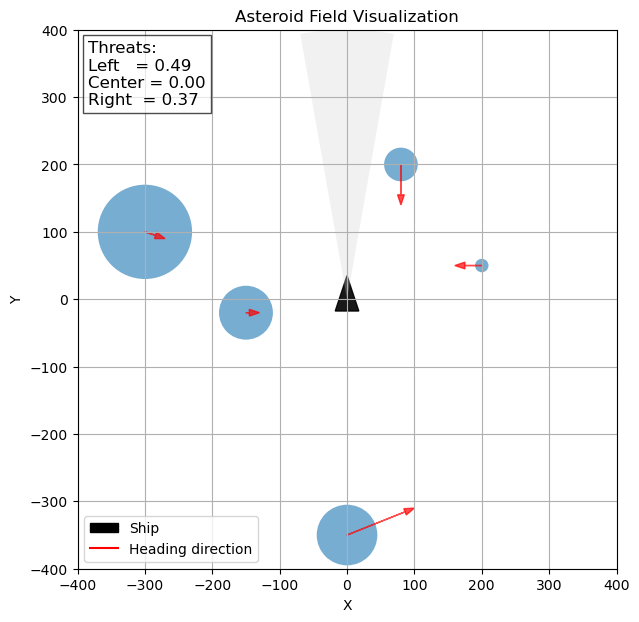

In [3]:
ship = Ship(x=0, y=0, vx=0, vy=0, heading=math.radians(90))
asteroids = [
    Asteroid(x=200, y=50, vx=-20, vy=0, size=10),
    Asteroid(x=-150, y=-20, vx=10, vy=0, size=40),
    Asteroid(x=80, y=200, vx=0, vy=-30, size=25),
    Asteroid(x=-300, y=100, vx=15, vy=-5, size=70),
    Asteroid(x=0, y=-350, vx=50, vy=20, size=45)]

game_state = GameState(ship=ship, asteroids=asteroids, bullets=[], t_s=0.0)
d_threat = compute_directional_threat(ship, asteroids, max_dist=400, max_size=50, theta_center_deg = 10)
print("Threats:", d_threat)
visualize_game(ship, asteroids, d_threat=d_threat, theta_center_deg = 10)

## 2. Generate Stimulus trains (Encoding game state)

Threat: Threat(left=0.49, center=0.0, right=0.37)
Stimulation Frequencies (Hz): StimFreqs(left_hz=27, center_hz=5, right_hz=22)


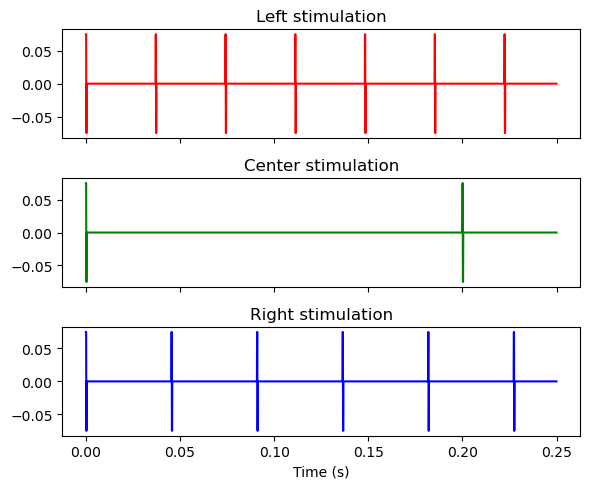

In [35]:
# Threat to stimulation frequencies
stim_freqs = map_threat_to_stim_freqs(d_threat)
print("Threat:", d_threat)
print("Stimulation Frequencies (Hz):", stim_freqs)
# Stimulation configuration
stim_cfg = StimConfig(
    sampling_rate=20_000,
    pulse_amplitude=0.075,   # 75 mV
    phase_width_s=200e-6,
    inter_phase_gap_s=0.0,
)
duration_s = 0.25
# Generate stimulation trains
stim_trains = generate_directional_trains(stim_freqs, duration_s, stim_cfg)
plot_directional_stim(stim_trains, stim_cfg)

## 4. Decoding game actions from BNN spikes

In [5]:
from utils.spikes_simulate import simulate_step_firing_counts
from utils.game_physics import DT
from utils.decoding import NeuralDecoder
from utils.closed_loop import update_game_state

# Simulated spikes from BNN for this 10 ms 
spike_counts = simulate_step_firing_counts(bin_duration_s=DT)
print("Firing counts:", spike_counts)

# Decode -> Action 
t_bin_end = game_state.t_s + DT
decoder = NeuralDecoder()

action = decoder.step(spike_counts, t_bin_end)
print("Action:", action)

# Update game state + hit/kill detection
hit, kill = update_game_state(game_state, action, DT)
print("Hit:", hit, "Kill:", kill)
print(
    f"Ship: x={game_state.ship.x:.1f}, y={game_state.ship.y:.1f}, "
    f"vx={game_state.ship.vx:.1f}, vy={game_state.ship.vy:.1f}, "
    f"heading_deg={math.degrees(game_state.ship.heading):.1f}"
)

Firing counts: FiringCounts(left=0, right=1, thrust=0, shoot=2)
Action: Action(heading=<Heading.RIGHT: 'right'>, thrust_on=False, shoot=True)
Hit: False Kill: False
Ship: x=0.0, y=0.0, vx=0.0, vy=0.0, heading_deg=91.8


## 5. Update game state + Evaluate hit / kill

In [30]:
# Update game state + hit/kill detection
hit, kill = update_game_state(game_state, action, DT)
print("Hit:", hit, "Kill:", kill)
print(
    f"Ship: x={game_state.ship.x:.1f}, y={game_state.ship.y:.1f}, "
    f"vx={game_state.ship.vx:.1f}, vy={game_state.ship.vy:.1f}, "
    f"heading_deg={math.degrees(game_state.ship.heading):.1f}"
)
print(
    f"Asteroid 1: x={game_state.asteroids[0].x:.1f}, y={game_state.asteroids[0].y:.1f}, "
    f"vx={game_state.asteroids[0].vx:.1f}, vy={game_state.asteroids[0].vy:.1f}"
)

Hit: False Kill: False
Ship: x=0.0, y=0.0, vx=0.0, vy=0.0, heading_deg=136.8
Asteroid 1: x=194.8, y=50.0, vx=-20.0, vy=0.0


In [34]:
from utils.closed_loop import step_feedback
from utils.feedback import FeedbackMode, FeedbackState
feedback_mode = FeedbackMode["LOOP1"]
fb_state = FeedbackState()
fb_type, pause_s, reset_game = step_feedback(feedback_mode, fb_state, hit, kill, DT)
print("Feedback:", fb_type, "pause_sensory:", pause_s, "reset_game:", reset_game)

Feedback: FeedbackType.NONE pause_sensory: 0.0 reset_game: False


## Check how feedback trains look for positive and negative reward

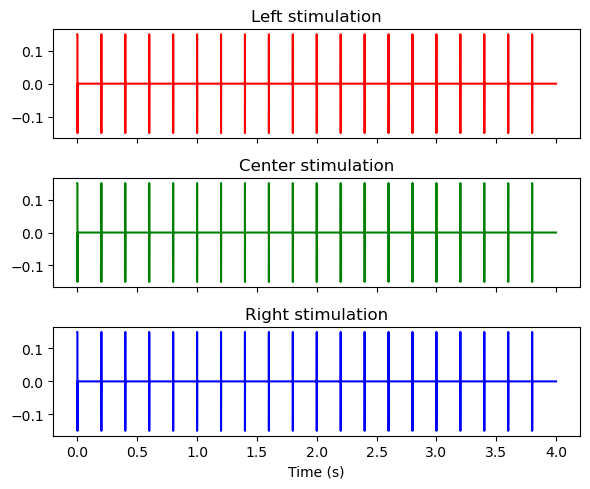

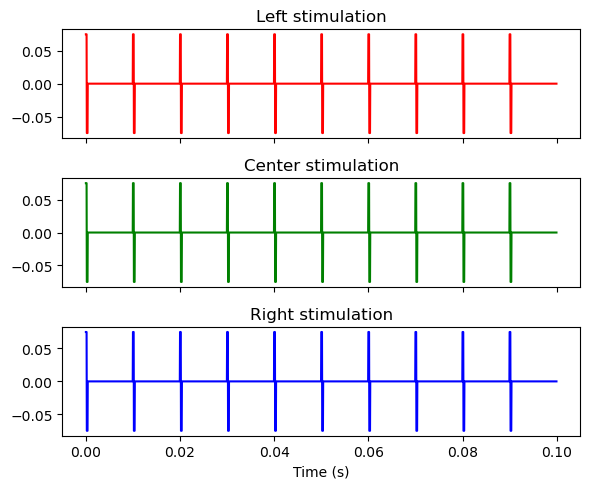

In [42]:
from utils.feedback import generate_feedback_trains, FeedbackType
# Punishment feedback trains
_, feedback_trains, _, _  = generate_feedback_trains(FeedbackType.PUNISHMENT, stim_cfg)
plot_directional_stim(feedback_trains, stim_cfg)
# Reward feedback trains
_, feedback_trains, _, _  = generate_feedback_trains(FeedbackType.KILL_REWARD, stim_cfg)
plot_directional_stim(feedback_trains, stim_cfg)    